In [1]:
#MACD Divergence and Crossover

In [2]:
#importing the important libraries
import numpy as np
import pandas as pd
import pandas_datareader as data
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#portfolio value for allocating using crossover 
co_portfolio = 1e5

#portfolio value for allocating using divergence 
div_portfolio = 1e5

#transaction cost as fraction
t_cost = 0.005

#list of stocks in portfolio
stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS']

#calculating the no. of stocks in the portfolio
nstocks=0
for stock in stock_list:
    nstocks+=1

In [4]:
# Function to read stock data
def read_data(ticker):
    df = data.DataReader(ticker, 'yahoo',start='1/1/2015')
    stocks.append(df)

In [6]:
# Function to generate macd line and signal line and related fields in all stock dataframe
def MACDLines(df):
    #Calculate 12 Day EMA
    df['12 Day EMA'] = df['Adj Close'].ewm(span=12).mean()
    
    #Calculate 26 Dat EMA
    df['26 Day EMA'] = df['Adj Close'].ewm(span=26).mean()
    
    #Calculate MACD value
    df['MACD line'] = df['12 Day EMA'] - df['26 Day EMA']
    
    #Calculate Signal line as 9 day EMA of MACD 
    df['Signal line'] = df['MACD line'].ewm(span=9).mean()
    
    # Initialize position based on crossover for each day as 0
    df['CO_Position'] = 0
    # Initialize position based on divergence for each day as 0
    df['Div_Position'] = 0

In [9]:
# Function to give positions for each day based on MACD crossover strategy

#Entry: If MACD line goes from above to below(yesterday it was above and today it is down) the Signal line then short the stock.
#       If MACD line goes from down to above (yesterday it was down and today it is above) the signal line then buy the stock.
#Exit: If you are long on the stock and the MACD line is below the signal line then exit the position
#      If you are short on the stock and the MACD line is above the signal line then exit the position


def MACDCross(df):
    for row in range(len(df)):
        if (df['CO_Position'].iloc[row-1]==0):
            if (df['MACD line'].iloc[row-1]>df['Signal line'].iloc[row-1]) and (df['MACD line'].iloc[row]<df['Signal line'].iloc[row]):
                df['CO_Position'].iloc[row] = -1
            if (df['MACD line'].iloc[row-1]<df['Signal line'].iloc[row-1]) and (df['MACD line'].iloc[row]>df['Signal line'].iloc[row]):
                df['CO_Position'].iloc[row] = 1
        
        
        if (df['CO_Position'].iloc[row-1]==1):
            if (df['MACD line'].iloc[row]<df['Signal line'].iloc[row]):
                df['CO_Position'].iloc[row]=0
            else:
                df['CO_Position'].iloc[row] = 1
        
        
        if (df['CO_Position'].iloc[row-1]==-1):
            if (df['MACD line'].iloc[row]>df['Signal line'].iloc[row]):
                df['CO_Position'].iloc[row]=0
            else:
                df['CO_Position'].iloc[row] = -1

In [10]:
#Function to give posiitions based on MACD DIvergence and not startegizing
# Entry: if the MACD value goes from negetive to positive, long the stock
#        if the MACD value goes from positive to negetive teritory short the stock
# Exit: if the MACD value again goes to negetive teritory then exit from long position
#       if the MACD value again goes to the positive teritory then exit the short position


########
# REVIEW COMMENTS: This is not actually a divergence strategy, but in fact, a zero line crossover
########
def MACD_div(df):
    for row in range(len(df)):
        if (df['Div_Position'].iloc[row-1]==0):
            if (df['MACD line'].iloc[row-1]<=0) and (df['MACD line'].iloc[row]>=0):
                df['Div_Position'].iloc[row]=1
            if (df['MACD line'].iloc[row-1]>=0) and (df['MACD line'].iloc[row]<=0):
                df['Div_Position'].iloc[row]=-1
                
        if (df['Div_Position'].iloc[row-1]==1):
            if (df['MACD line'].iloc[row]<0):
                df['Div_Position'].iloc[row]=0
            else:
                df['Div_Position'].iloc[row]=1
                
        if (df['Div_Position'].iloc[row-1]==-1):
            if (df['MACD line'].iloc[row]>0):
                df['Div_Position'].iloc[row]=0
            else:
                df['Div_Position'].iloc[row]=-1

In [11]:
#Initialize the list of stock dataframes
stocks = []

#Iterate and make the dataframes using the functions
i = 0
for ticker in stock_list:
    
    #reading data for each stock
    read_data(ticker)
    
    #MACD line for each stock
    MACDLines(stocks[i])
    
    # taking position by MACD Crossover strategy
    MACDCross(stocks[i])
    
    # taking position by MACD Divergence strategy
    MACD_div(stocks[i])
    i+=1

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\u

In [14]:
# setting the dimensions of the weights vector depending on the available data points
s = (len(stocks[0]),nstocks) 

#Inititializing the weight vector of each stock each day to be 0
co_weights = np.zeros(s)
div_weights = np.zeros(s)

#Giving weights for crossover portfolio
sumwts=0
for row in range(len(stocks[0])):
    
    # Calculating no. of position taken that day
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['CO_Position'].iloc[row]) 
    
    
    #Calculating weights for each day
    for i in range(nstocks):
        if sumwts>0:
            co_weights[row][i]=(co_portfolio*stocks[i]['CO_Position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+t_cost))



#Giving weights for divergence portfolio
sumwts=0
for row in range(len(stocks[0])):
    
    # Calculating no. of position taken that day
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['Div_Position'].iloc[row]) 
    
    
    #Calculating weights for each day
    for i in range(nstocks):
        if sumwts>0:
            div_weights[row][i]=(div_portfolio*stocks[i]['Div_Position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+t_cost))


            
#Calculating market return
for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1))

    
#Calculating portfolio return for crossover
stocks[0]['Crossover Strategy Return']=0
for i in range(nstocks):
    stocks[0]['Crossover Strategy Return']+=stocks[i]['Market Return'] * co_weights[:,i]

    
    
#Calculating portfolio return for divergence
stocks[0]['Divergence Strategy Return']=0
for i in range(nstocks):
    stocks[0]['Divergence Strategy Return']+=stocks[i]['Market Return'] * div_weights[:,i]

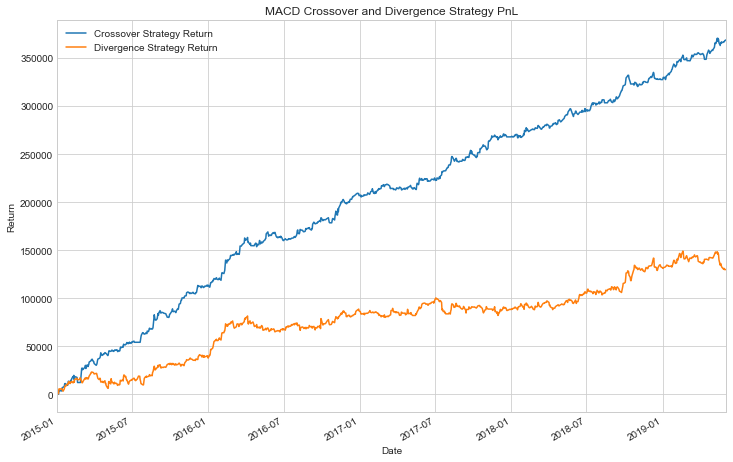

In [17]:
#Plotting both strategy returns
stocks[0]['Crossover Strategy Return'].cumsum().plot(figsize=(12,8), label='Crossover Strategy Return')
stocks[0]['Divergence Strategy Return'].cumsum().plot(label='Divergence Strategy Return')
plt.style.use('seaborn-whitegrid')
plt.ylabel('Return')
plt.xlabel('Date')
plt.title('MACD Crossover and Divergence Strategy PnL')
plt.legend()